In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cvxportfolio as cp

plotdir = '../portfolio/plots/'
datadir='../data/'

sigmas=pd.read_csv(datadir+'sigmas.csv.gz',index_col=0,parse_dates=[0]).iloc[:,:-1]
returns=pd.read_csv(datadir+'returns.csv.gz',index_col=0,parse_dates=[0])
volumes=pd.read_csv(datadir+'volumes.csv.gz',index_col=0,parse_dates=[0]).iloc[:,:-1]

w_b = pd.Series(index=returns.columns, data=1)
w_b.USDOLLAR = 0.
w_b/=sum(w_b)

start_t="2012-01-01"
end_t="2016-12-31"

simulated_tcost = cp.TcostModel(half_spread=0.0005/2., nonlin_coeff=1., sigma=sigmas, volume=volumes)
simulated_hcost = cp.HcostModel(borrow_costs=0.0001)
simulator = cp.MarketSimulator(returns, costs=[simulated_tcost, simulated_hcost],
                               market_volumes=volumes, cash_key='USDOLLAR')

return_estimate=pd.read_csv(datadir+'return_estimate.csv.gz',index_col=0,parse_dates=[0])
volume_estimate=pd.read_csv(datadir+'volume_estimate.csv.gz',index_col=0,parse_dates=[0])
sigma_estimate=pd.read_csv(datadir+'sigma_estimate.csv.gz',index_col=0,parse_dates=[0])

#alpha_model = cp.AlphaSource(return_estimate)
optimization_tcost=cp.TcostModel(half_spread=0.0005/2., nonlin_coeff=1., 
                                 sigma=sigma_estimate, volume=volume_estimate)
optimization_hcost=cp.HcostModel(borrow_costs=0.0001)

risk_data = pd.HDFStore(datadir+'risk_model.h5')
risk_model = cp.FactorModelSigma(risk_data.exposures, risk_data.factor_sigma, risk_data.idyos)

results={}

In [2]:
import sys
import cvxpy as cvx
from io import TextIOWrapper, BytesIO
solver=cvx.ECOS

# setup the environment
old_stdout = sys.stdout
sys.stdout = TextIOWrapper(BytesIO(), sys.stdout.encoding)

policy=cp.SinglePeriodOpt(return_estimate, 
                          [1*risk_model,1*optimization_tcost,optimization_hcost], 
                          [cp.LeverageLimit(3)],
                          solver_opts={'verbose':True}, solver=solver)
result=simulator.run_backtest(1E8*w_b, start_time=start_t,end_time=end_t,#'2012-01-31',
                              policy=policy)

# get output
sys.stdout.seek(0)      # jump to the start
out = sys.stdout.read() # read output

# restore stdout
sys.stdout.close()
sys.stdout = old_stdout

In [3]:
if solver==cvx.ECOS:
    solver_times=pd.Series(index=result.simulation_time.index,
                     data=[float(line[8:17]) for line in out.split('\n')if line[:7]=='Runtime'])

Text(0,0.5,'Seconds')

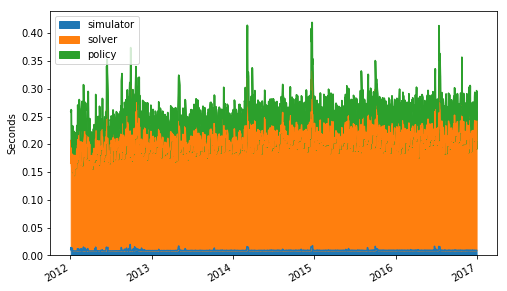

In [4]:
df=pd.DataFrame({'solver':solver_times, 'simulator':result.simulation_time,
             'policy':result.policy_time-solver_times})
df=df[['simulator','solver','policy',]]
df.plot.area(figsize=(8,5))
plt.ylabel('Seconds')
#plt.savefig(plotdir+'execution_time.png')